https://www.kaggle.com/datasets/rdataenthusiast/stress-level-prediction-in-sleep?select=StressLevelPrediction-Sleep.csv

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import google.colab
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats
from sklearn.feature_selection import f_classif

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sleep_df = pd.read_csv("/content/drive/MyDrive/project/StressFromSleepAndOx.csv")

In [4]:
sleep_df.head(2000)

,age,marital status,gender,bmi,snoring rate,respiration rate,body temperature,limb movement,blood oxygen,eye movement,sleeping hours,heart rate,stress level
0,67.00,0,Male,36.6,23.0,18.0,90.330,16.600,97.000,20.0,1.840,74.20,1
1,61.00,0,Female,NaN,15.0,15.0,90.410,15.880,96.000,22.0,1.552,72.76,1
2,80.00,0,Male,32.5,11.0,20.0,96.120,10.000,95.000,25.0,7.000,60.00,2
3,49.00,0,Female,34.4,8.0,19.0,96.640,13.920,95.000,23.0,0.768,68.84,2
4,79.00,1,Female,24.0,11.0,12.0,79.870,6.496,90.000,20.0,8.248,53.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,71.00,1,Male,33.3,10.0,13.0,93.520,11.520,91.520,24.0,4.280,63.80,2
1996,32.00,1,Female,22.6,28.0,15.0,93.696,11.696,91.696,24.0,4.544,64.24,2
1997,32.00,0,Female,26.3,16.0,14.0,90.000,12.000,88.000,24.0,0.000,65.00,3
1998,63.00,1,Female,29.7,99.0,15.0,89.520,18.808,87.424,25.0,0.000,84.04,3


In [5]:
df = sleep_df.copy()

In [6]:
min_values = df.min()
max_values = df.max()

# Combine results into a single DataFrame
min_max_df = pd.DataFrame({'Min': min_values, 'Max': max_values})

print(min_max_df)

                     Min     Max
age                 0.08    82.0
marital status         0       1
gender            Female    Male
bmi                 11.3    97.6
snoring rate         0.0    99.0
respiration rate    10.0    25.0
body temperature   79.03    99.5
limb movement        0.0    25.0
blood oxygen        75.0    99.0
eye movement        20.0  104.96
sleeping hours       0.0     9.0
heart rate          50.0    90.0
stress level           0       4


In [7]:
df.groupby('stress level').size()

,0
stress level,
0,3308
1,4200
2,4379
3,4033
4,3280


In [8]:
print(len(df))

19200


In [9]:
import pandas as pd

def find_bad_rows(df):
    """Finds rows with 'other' values or non-numeric values where numbers are expected."""
    bad_rows_indices = []

    # Iterate through each column
    for col in df.columns:
      # Handle cases where columns might be numeric
        if pd.api.types.is_numeric_dtype(df[col]):
          # Attempt to convert to numeric, catching errors for non-numeric values
            try:
                pd.to_numeric(df[col])
            except (ValueError, TypeError):
                bad_rows_indices.extend(df[pd.to_numeric(df[col], errors='coerce').isnull()].index)

        elif 'other' in df[col].astype(str).str.lower().values:
            bad_rows_indices.extend(df[df[col].astype(str).str.lower().str.contains('other')].index)

    # Return only unique bad row indices
    return df.iloc[list(set(bad_rows_indices))]

bad_rows = find_bad_rows(sleep_df)
bad_rows

,age,marital status,gender,bmi,snoring rate,respiration rate,body temperature,limb movement,blood oxygen,eye movement,sleeping hours,heart rate,stress level


In [10]:
print(df.columns)

Index(['age', 'marital status', 'gender', 'bmi', 'snoring rate',
       'respiration rate', 'body temperature', 'limb movement', 'blood oxygen',
       'eye movement', 'sleeping hours', 'heart rate', 'stress level'],
      dtype='object')


In [11]:
# Keep only interesting columns
df = df[['blood oxygen', 'sleeping hours', 'stress level']]

print(df.head())


   blood oxygen  sleeping hours  stress level
0          97.0           1.840             1
1          96.0           1.552             1
2          95.0           7.000             2
3          95.0           0.768             2
4          90.0           8.248             0


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, InputLayer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Drop any rows with missing values in key columns
df = df.dropna(subset=['blood oxygen', 'sleeping hours', 'stress level'])

# Features and labels
X = df[['blood oxygen', 'sleeping hours']].values
y = df['stress level'].values

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target
encoder = OneHotEncoder(sparse_output=False, categories=[np.arange(5)])
y_encoded = encoder.fit_transform(y.reshape(-1, 1))



    # Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [13]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.05, epochs=50, batch_size=32)

# Evaluate the model
loss, metric = model.evaluate(X_test, y_test)
print(f"Test accuracy: {metric}")


Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5317 - loss: 1.2107 - val_accuracy: 0.7797 - val_loss: 0.7855
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7629 - loss: 0.7931 - val_accuracy: 0.8044 - val_loss: 0.6686
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7800 - loss: 0.7059 - val_accuracy: 0.7849 - val_loss: 0.5972
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7876 - loss: 0.6623 - val_accuracy: 0.8044 - val_loss: 0.5646
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8057 - loss: 0.6007 - val_accuracy: 0.8214 - val_loss: 0.5335
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8097 - loss: 0.5922 - val_accuracy: 0.8240 - val_loss: 0.5115
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8112 - loss: 0.5873 - val_accuracy: 0.7992 - val_loss: 0.5145
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8215 - loss: 0.5482 - val_accuracy: 0.

In [15]:
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming a multi-class classification problem
y_test_classes = np.argmax(y_test, axis=1)

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Precision: 0.853872555332843
Recall: 0.8510305243934255
Accuracy: 0.8510305243934255
F1 Score: 0.8514684713278692
Matthews Correlation Coefficient: 0.8136995563045806
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82       667
           1       0.86      0.83      0.84       841
           2       0.87      0.81      0.84       913
           3       0.84      0.84      0.84       784
           4       0.95      0.93      0.94       628

    accuracy                           0.85      3833
   macro avg       0.85      0.86      0.85      3833
weighted avg       0.85      0.85      0.85      3833



Text(50.722222222222214, 0.5, 'True Labels')

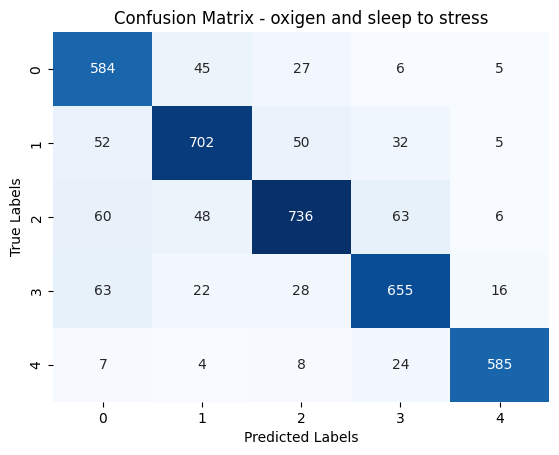

In [17]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, matthews_corrcoef, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Assuming you have true labels in y_test
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient:", mcc)
print("Classification Report:\n", report)
plt.title('Confusion Matrix - oxigen and sleep to stress')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#disp = ConfusionMatrixDisplay(cm, display_labels=['Stress 0', 'Stress 1','Stress 2','Stress 3','Stress 4'])
#disp.plot()

In [ ]:
probs = model.predict(X_test)
print(probs)
predicted_class = np.argmax(probs, axis=1)
print(predicted_class)

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[6.82833663e-04 3.32130864e-03 4.31451574e-03 4.65750173e-02
  9.45106268e-01]
 [8.83318663e-01 1.59555506e-02 3.23189273e-02 6.01815730e-02
  8.22530407e-03]
 [1.13548934e-01 2.65661210e-01 1.28686547e-01 2.99737751e-01
  1.92365453e-01]
 ...
 [4.00799094e-04 6.79862278e-04 3.24681657e-03 9.92107987e-01
  3.56450398e-03]
 [3.52366106e-03 9.81410563e-01 7.19290739e-03 4.69058380e-03
  3.18231829e-03]
 [1.51276327e-04 3.17856466e-04 1.41153252e-03 9.95045185e-01
  3.07410699e-03]]
[4 0 3 ... 3 1 3]


In [ ]:
model.save("stress_from_sleep_and_ox_model.keras")
model.save("stress_from_sleep_and_ox_model.h5")

import joblib

# Save
joblib.dump(scaler, 'ox_and_sleep_scaler.pkl')

['ox_and_sleep_scaler.pkl']

In [ ]:
from google.colab import files
files.download("stress_from_sleep_and_ox_model.keras")
files.download("stress_from_sleep_and_ox_model.h5")
files.download('ox_and_sleep_scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>